# Library loading

First, we load all the libraries that we will use in this notebook and set some options.

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

Then, we open the database from the liga.sqlite file and save it to a dataframe named "df". We chack for completely empty rows and, if there's any, we drop them.

In [2]:
conn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())
display(df.tail())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


,season,division,matchday,date,time,home_team,away_team,score
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None
48779,2021-2022,2,42,5/29/22,None,Real Valladolid,SD Huesca,None


Since there are several matches that don't have score (they haven't been played when the database was extracted), we have to get rid of them because they don't give any useful information. Moreover, as the matchday 3 of season 2021-2022 is not complete, we also delete it.

In [3]:
df = df[~((df['season'] == "2021-2022") & (df['matchday'] > 2))]
df.tail()

,season,division,matchday,date,time,home_team,away_team,score
48335,2021-2022,2,2,8/22/21,7:30 PM,SD Eibar,Ponferradina,0:1
48336,2021-2022,2,2,8/22/21,7:30 PM,Girona,UD Las Palmas,0:0
48337,2021-2022,2,2,8/22/21,10:00 PM,SD Huesca,FC Cartagena,2:0
48338,2021-2022,2,2,8/23/21,8:00 PM,CD Mirandés,SD Amorebieta,2:0
48339,2021-2022,2,2,8/23/21,10:00 PM,CD Leganés,Burgos CF,0:0


# Data exploration

First of all, we should know the data types of each column.

In [4]:
df.dtypes

season       object
division      int64
matchday      int64
date         object
time         object
home_team    object
away_team    object
score        object
dtype: object

How many teams do we have?

In [5]:
print(f"We have {len(df['home_team'].unique())} teams that have played at home.")
print(f"We have {len(df['away_team'].unique())} teams that have played as visitors.")
print(f"And those teams are:\n {df['home_team'].unique()}.")

We have 151 teams that have played at home.
We have 152 teams that have played as visitors.
And those teams are:
 ['Arenas Club' 'Espanyol' 'Real Madrid' 'Donostia' 'Racing' 'Barcelona'
 'Athletic' 'Athletic Madrid' 'Real Unión' 'Catalunya' 'Alavés' 'Valencia'
 'Real Betis' 'Real Oviedo' 'Sevilla FC' 'Hércules CF' 'CA Osasuna'
 'Real Zaragoza' 'Celta de Vigo' 'Ath. Aviación' 'Real Murcia'
 'Atl. Aviación' 'Granada CF' 'Dep. La Coruña' 'Real Sociedad'
 'CD Castellón' 'CE Sabadell ' 'Real Gijón' 'CD Alcoyano' 'Gimnàstic'
 'Atlético Madrid' 'Real Valladolid' 'CD Málaga' 'Lérida'
 'Atlético Tetuán' 'UD Las Palmas' 'Real Jaén CF' 'CyD Leonesa'
 'CD Condal' 'Elche CF' 'RCD Mallorca' 'CD Tenerife' 'Córdoba CF'
 'Pontevedra' 'Levante' 'Sporting Gijón' 'Burgos CF' 'UD Salamanca'
 'Cádiz CF' 'Rayo Vallecano' 'Recr. Huelva' 'AD Almería' 'CD Logroñés'
 'Albacete' 'UE Lleida' 'SD Compostela' 'CP Mérida' 'CF Extremadura'
 'Villarreal' 'Málaga CF' 'CD Numancia' 'Getafe' 'UD Almería' 'Xerez CD'
 'SD E

As we can notice, we have one team that has played as a visitor but never as a local. This one is the `SD Amorebieta` that was promoted to 2nd division for the first time in 2021, but played the first two matches as a visitor.

However, upon further research, we found that some of the names correspond to the same team, which underwent renaming or rebranding. To address this, we should standardize the names to ensure consistency. We consider a team to remain the same after a rebranding, as there are instances where teams have disappeared, and their spots were filled by their second teams, which were not affiliated at the time and thus were not legally the same team.

In [6]:
df['home_team'] = df['home_team'].apply(lambda x: 'Atlético Madrid' if x == 'Athletic Madrid'
                                         else 'Real Sociedad' if x == 'Donostia'
                                         else 'CE Europa' if x == 'Catalunya'
                                         else 'Atlético Madrid' if x == 'Ath. Aviación'
                                         else 'Atlético Madrid' if x == 'Atl. Aviación'
                                         else 'UE Lleida' if x == 'Lérida'
                                         else 'UD Almería' if x == 'AD Almería'
                                         else 'Sporting Gijón' if x == 'Real Gijón'
                                         else 'Gimnàstic' if x == 'Gimnástica'
                                         else 'Ciudad Murcia' if x == 'Granada 74 CF'
                                         else 'UD Las Palmas' if x == 'Uni. Las Palmas'
                                         else 'Racing Ferrol' if x == 'Ferrol'
                                         else 'Terrassa FC' if x == 'Tarrasa'
                                         else 'Barcelona B' if x == 'Barcelona Atl.'
                                         else 'RM Castilla' if x == 'Castilla CF'
                                         else x)

df['away_team'] = df['away_team'].apply(lambda x: 'Atlético Madrid' if x == 'Athletic Madrid'
                                         else 'Real Sociedad' if x == 'Donostia'
                                         else 'CE Europa' if x == 'Catalunya'
                                         else 'Atlético Madrid' if x == 'Ath. Aviación'
                                         else 'Atlético Madrid' if x == 'Atl. Aviación'
                                         else 'UE Lleida' if x == 'Lérida'
                                         else 'UD Almería' if x == 'AD Almería'
                                         else 'Sporting Gijón' if x == 'Real Gijón'
                                         else 'Gimnàstic' if x == 'Gimnástica'
                                         else 'Ciudad Murcia' if x == 'Granada 74 CF'
                                         else 'UD Las Palmas' if x == 'Uni. Las Palmas'
                                         else 'Racing Ferrol' if x == 'Ferrol'
                                         else 'Terrassa FC' if x == 'Tarrasa'
                                         else 'Barcelona B' if x == 'Barcelona Atl.'
                                         else 'RM Castilla' if x == 'Castilla CF'
                                        else x)

print(f"We have {len(df['home_team'].unique())} teams that have played at home.")
print(f"We have {len(df['away_team'].unique())} teams that have played as visitors.")
print(f"And those teams are:\n {df['home_team'].unique()}.")

We have 136 teams that have played at home.
We have 137 teams that have played as visitors.
And those teams are:
 ['Arenas Club' 'Espanyol' 'Real Madrid' 'Real Sociedad' 'Racing'
 'Barcelona' 'Athletic' 'Atlético Madrid' 'Real Unión' 'CE Europa'
 'Alavés' 'Valencia' 'Real Betis' 'Real Oviedo' 'Sevilla FC' 'Hércules CF'
 'CA Osasuna' 'Real Zaragoza' 'Celta de Vigo' 'Real Murcia' 'Granada CF'
 'Dep. La Coruña' 'CD Castellón' 'CE Sabadell ' 'Sporting Gijón'
 'CD Alcoyano' 'Gimnàstic' 'Real Valladolid' 'CD Málaga' 'UE Lleida'
 'Atlético Tetuán' 'UD Las Palmas' 'Real Jaén CF' 'CyD Leonesa'
 'CD Condal' 'Elche CF' 'RCD Mallorca' 'CD Tenerife' 'Córdoba CF'
 'Pontevedra' 'Levante' 'Burgos CF' 'UD Salamanca' 'Cádiz CF'
 'Rayo Vallecano' 'Recr. Huelva' 'UD Almería' 'CD Logroñés' 'Albacete'
 'SD Compostela' 'CP Mérida' 'CF Extremadura' 'Villarreal' 'Málaga CF'
 'CD Numancia' 'Getafe' 'Xerez CD' 'SD Eibar' 'CD Leganés' 'Girona'
 'SD Huesca' 'Baracaldo' 'Racing Ferrol' 'Avilés Ind.' 'SD Ceuta'
 'CE

We can check the divisions seasons we have in the data frame.

In [7]:
print(f"The dataset has {len(df['division'].unique())} divisions.")
print(f"The dataset contains info from {len(df['season'].unique())} seasons.")

The dataset has 2 divisions.
The dataset contains info from 91 seasons.


We can also check the different scores the dataset has:

In [8]:
df["score"].unique()

array(['2:3', '3:2', '5:0', '1:1', '0:2', '1:2', '9:0', '0:3', '3:1',
       '5:2', '3:0', '0:4', '2:1', '2:2', '2:0', '3:3', '4:1', '1:3',
       '1:0', '4:0', '6:3', '8:1', '5:1', '4:3', '4:2', '0:1', '0:0',
       '5:4', '7:1', '6:1', '5:3', '7:0', '2:5', '2:4', '6:0', '4:4',
       '1:4', '7:2', '1:7', '8:2', '3:4', '6:2', '0:6', '12:1', '4:7',
       '1:5', '6:4', '9:1', '9:5', '8:0', '7:3', '8:3', '3:5', '0:5',
       '2:6', '4:5', '7:5', '11:1', '10:3', '10:0', '5:5', '9:2', '9:3',
       '3:6', '7:4', '2:7', '10:1', '6:6', '1:6', '9:4', '5:6', '0:7',
       '1:8', '0:8', '11:2', '4:6', '2:8', '3:8', '10:2', '14:2', '6:5',
       '3:7', '11:0'], dtype=object)

# Create some features

ERASE THIS WHEN FINISHED
- Scores and results
- Rank of 2nd tier teams
- Mean rank of the last 5 seasons
- Number of teams of the second divison

To start, we split the data contained within the `score` column into the performance of the team playing at home (`home_score`) and the team playing as visitors (`away_score`).

In [9]:
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])

We changed the `season` column to numerical to ease later steps when calculating teams' performance.

In [10]:
df["season"] = pd.to_numeric(df["season"].str[-4:])

Using the `score` of the `away_team` and the `home_team` we can compute the `result` of each match. This is encoded in the classic La Quiniela notation, where a home win is `1`, an away win is `2` and a tie corresponds to `X`.

In [11]:
df['result'] = df.apply(lambda df: '1' if df['home_score'] > df['away_score']
                                        else '2' if df['home_score'] < df['away_score']
                                        else 'X', axis=1)

Next we will create two new data frames in order to store the data for the teams when playing at home an when they play as visitors. Once we have them, we concatenate them putting zeros where there is no information availiable.

In [12]:
df['home_W'] = (df['result'] == '1').astype(int)
df['home_L'] = (df['result'] == '2').astype(int)
df['home_T'] = (df['result'] == 'X').astype(int)
df['away_W'] = (df['result'] == '2').astype(int)
df['away_L'] = (df['result'] == '1').astype(int)
df['away_T'] = (df['result'] == 'X').astype(int)

home_df = df[['season', 'division', 'matchday', 'home_team', 'home_score', 'away_score','home_score', 'away_score', 'home_W', 'home_L', 'home_T']]
home_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','home_GF', 'home_GA', 'W', 'L', 'T']

away_df = df[['season', 'division', 'matchday', 'away_team', 'away_score', 'home_score','away_score', 'home_score', 'away_W', 'away_L', 'away_T']]
away_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','away_GF', 'away_GA', 'W', 'L', 'T']

team_results = pd.concat([home_df, away_df])
team_results.fillna(0,inplace=True)

Then, we store in the `matchday_standings` dataframe the cummulatives of the different variables to have the information of the previous matches of the season for each team. We also compute the goal difference, the number of matches played and the points for each of them. 

In [13]:
matchday_standings = team_results.sort_values(['season', 'division', 'team', 'matchday'])
matchday_standings[['GF', 'GA','home_GF',
                    'home_GA','away_GF','away_GA', 
                    'W', 'L', 'T']] = matchday_standings.groupby(['season', 'division', 'team'])[['GF', 'GA','home_GF',
                                                                                                  'home_GA','away_GF','away_GA', 
                                                                                                  'W', 'L', 'T']].cumsum()

matchday_standings['GD'] = matchday_standings['GF'] - matchday_standings['GA']
matchday_standings['M'] = matchday_standings['W'] + matchday_standings['L'] + matchday_standings['T']
matchday_standings['Pts'] = matchday_standings['W'] * 3 + matchday_standings['T']

We have also created a column to store the last five results for each team (`last_5`), encoded by `W` for a win, `T` for a tie and `L` for a defeat. We add them to each team of the `matchday_standings` dataframe, together with their `rank` at the corresponding `season`, `division` and `matchday`.

In [14]:
team_results['result'] = team_results.apply(lambda row: 'W' if row['W'] == 1 else 'L' if row['L'] == 1 else 'T', axis=1)
team_results.sort_values(['season', 'division', 'team', 'matchday'],inplace = True)

last_results = team_results.groupby(['season', 'division', 'team'])['result'].apply(
    lambda x: np.array([np.array(rolling_list) for rolling_list in x.rolling(5)],dtype=object))
matchday_standings["last_5"] = np.concatenate(last_results.values).reshape(-1)

matchday_standings = matchday_standings.sort_values(by=['season','division', 'matchday',
                                                  'Pts', 'GD', 'GF'],
                                              ascending=[True, True,True,
                                                         False, False, False])


matchday_standings.insert(3,'rank',matchday_standings.groupby(['season','division',
                                                   'matchday'])['Pts'].rank(ascending=False,
                                                                            method='first'))

We compute the cumulative average goals as they can be good parameters to describe a team's seasonal performance.

In [15]:
matchday_standings['home_avg_GF'] = matchday_standings['home_GF']/ matchday_standings['matchday']
matchday_standings['home_avg_GA'] = matchday_standings['home_GA']/ matchday_standings['matchday']
matchday_standings['away_avg_GF'] = matchday_standings['away_GF'] / matchday_standings['matchday']
matchday_standings['away_avg_GA'] = matchday_standings['away_GA'] / matchday_standings['matchday']
matchday_standings['avg_GF'] = matchday_standings['GF'] / matchday_standings['matchday']
matchday_standings['avg_GA'] = matchday_standings['GA'] / matchday_standings['matchday']

We can also calculate the points earned in the last five games. To do it, we create a function that reads the `last_5` results, and sums the corresponding points.

In [16]:
def calculate_points(last_5):
    points = {'W': 3, 'T': 1, 'L': 0}
    total_points = sum(points[res] for res in last_5 if res in points)
    return total_points / len(last_5) if len(last_5) > 0 else 0

matchday_standings['avg_points_last_5'] = matchday_standings['last_5'].apply(calculate_points)

The variable `rank_5_last_seasons` describes the rank of each team during the last 5 seasons. After computing it, we merge this variable to `matchday_standings` data frame.

In [17]:
last_game_rankings = matchday_standings.sort_values(by=['season', 'division',
                                                        'team', 'matchday']).groupby(['season',
                                                                                      'division', 'team']).last().reset_index()
last_game_rankings.loc[last_game_rankings['division'] == 2, 'rank'] += 20
last_game_rankings["rank_5_last_seasons"] = last_game_rankings.groupby('team')['rank'].transform(lambda x: x.rolling(window=5,
                                                                                                                     min_periods=1).mean())

last_game_rankings["season"] = last_game_rankings["season"] + 1

matchday_standings = matchday_standings.merge(
    last_game_rankings[['season', 'division', 'team', 'rank_5_last_seasons']],
    on=['season', 'division', 'team'],
    how='left')

matchday_standings

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5,rank_5_last_seasons
0,1929,1,1,1.0,Real Madrid,5,0,5.0,0.0,1,...,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0,NaN
1,1929,1,1,2.0,Barcelona,2,0,0.0,0.0,1,...,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0,NaN
2,1929,1,1,3.0,Atlético Madrid,3,2,0.0,0.0,1,...,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0,NaN
3,1929,1,1,4.0,Espanyol,3,2,3.0,2.0,1,...,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0,NaN
4,1929,1,1,5.0,Athletic,1,1,0.0,0.0,0,...,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95955,2022,2,2,18.0,Real Zaragoza,0,2,0.0,0.0,0,...,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5,30.6
95956,2022,2,2,19.0,Alcorcón,0,3,0.0,2.0,0,...,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0,34.4
95957,2022,2,2,20.0,SD Eibar,0,3,0.0,1.0,0,...,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0,NaN
95958,2022,2,2,21.0,FC Cartagena,1,5,1.0,3.0,0,...,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0,33.5


It is observed that several rows lack records for the last 5 seasons' ranks. This is due to various reasons, the most common of which are:

- Some teams got promoted from 3rd division, so we don't have information about them.
- All entries from the first season (1929) are NaN since we don't have older registries in the database.

To enable sorting by season and team rank, we need to adjust the ranks for second-division teams. Since we calculated their maximum rank within each division, the index resets between divisions.

In [18]:
max_rank_by_season = matchday_standings.groupby(['season', 'division'])['rank'].max().reset_index()
max_rank_by_season.columns = ['season', 'division', 'max_rank']

max_rank_div1_by_season = matchday_standings[matchday_standings['division'] == 1].groupby('season')['rank'].max().reset_index()
max_rank_div1_by_season.columns = ['season', 'max_rank_div1']

matchday_standings = matchday_standings.merge(max_rank_by_season, on=['season', 'division'], how='left')
matchday_standings = matchday_standings.merge(max_rank_div1_by_season, on='season', how='left')

matchday_standings['rank_5_last_seasons'] = np.where(
    matchday_standings['rank_5_last_seasons'].isna(),
    np.where(
        matchday_standings['season'] == 1929, 
        0, 
        np.where(
            matchday_standings['division'] == 2,
            matchday_standings['max_rank_div1'] + matchday_standings['max_rank'] + 1,
            matchday_standings['max_rank'] + 1  
        )
    ),
    matchday_standings['rank_5_last_seasons']
)


matchday_standings.drop(columns=['max_rank', 'max_rank_div1'],inplace=True)

display(matchday_standings)

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5,rank_5_last_seasons
0,1929,1,1,1.0,Real Madrid,5,0,5.0,0.0,1,...,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0
1,1929,1,1,2.0,Barcelona,2,0,0.0,0.0,1,...,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0
2,1929,1,1,3.0,Atlético Madrid,3,2,0.0,0.0,1,...,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0,0.0
3,1929,1,1,4.0,Espanyol,3,2,3.0,2.0,1,...,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0,0.0
4,1929,1,1,5.0,Athletic,1,1,0.0,0.0,0,...,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95955,2022,2,2,18.0,Real Zaragoza,0,2,0.0,0.0,0,...,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5,30.6
95956,2022,2,2,19.0,Alcorcón,0,3,0.0,2.0,0,...,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0,34.4
95957,2022,2,2,20.0,SD Eibar,0,3,0.0,1.0,0,...,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0,43.0
95958,2022,2,2,21.0,FC Cartagena,1,5,1.0,3.0,0,...,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0,33.5


We then split the features computed in two dataframes: one with the stats when playing at home, and the other one with the stats when playing away. Then, we rename some of the columns to be more precise with their names and to avoid possible mistakes.

In [19]:
home_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank', 
                                                       'avg_GF', 'avg_GA', 'home_avg_GF', 'home_avg_GA', 
                                                       'avg_points_last_5','rank_5_last_seasons']]
        
away_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank', 
                                                'avg_GF', 'avg_GA', 'away_avg_GF', 'away_avg_GA', 
                                                'avg_points_last_5','rank_5_last_seasons']]

home_stats = home_stats.rename(columns={
    'team': 'home_team',
    'rank': 'home_rank',
    'avg_GF': 'home_total_avg_GF',
    'avg_GA': 'home_total_avg_GA',
    'home_avg_GF': 'home_GF_avg',
    'home_avg_GA': 'home_GA_avg',
    'avg_points_last_5': 'home_avg_points_last_5',
    'rank_5_last_seasons' : 'home_rank_5_last_seasons'
})

away_stats = away_stats.rename(columns={
    'team': 'away_team',
    'rank': 'away_rank',
    'avg_GF': 'away_total_avg_GF',
    'avg_GA': 'away_total_avg_GA',
    'away_avg_GF': 'away_GF_avg',
    'away_avg_GA': 'away_GA_avg',
    'avg_points_last_5': 'away_avg_points_last_5',
    'rank_5_last_seasons' : 'away_rank_5_last_seasons'
})

And then we merge the data frames to the original data frame to store all the features we have calculated for the teams when playing at home and as visitors. Since we want to add at each matchday the information about the previous ones, we have to merge them considering the previous matchday from the original dataframe `df`.

In [20]:
df["matchday"] = df["matchday"] - 1
df = df.merge(home_stats, on=['season', 'division', 'matchday', 'home_team'], how='left')
df = df.merge(away_stats, on=['season', 'division', 'matchday', 'away_team'], how='left')
df["matchday"] = df["matchday"] + 1

# Reorder the columns
df = df[["season","division","matchday","home_team","away_team","result","home_score","away_score","home_W","home_L","home_T","home_rank","away_rank",
         "home_total_avg_GA","home_total_avg_GF","away_total_avg_GA","away_total_avg_GF","home_GF_avg",
         "home_GA_avg","away_GF_avg","away_GA_avg","home_avg_points_last_5","away_avg_points_last_5",
         "home_rank_5_last_seasons","away_rank_5_last_seasons"]]
df.fillna(0,inplace=True)

We can compute other useful features using the previous ones. Among these there are the `expected_home_goals` and `expected_away_goals`, which is the mean between the goals the corresponding team scores and the goals concedes by the rival. We also compute the difference between the mean of the last 5 seasons between the two teams.

In [21]:
df["dif_rank"] = df["home_rank"] - df["away_rank"]
df["expected_home_goals"] = (df["home_GF_avg"] + df["away_GA_avg"])/2
df["expected_away_goals"] = (df["away_GF_avg"] + df["home_GA_avg"])/2
df["dif_last5_points"] = df["home_avg_points_last_5"] - df["away_avg_points_last_5"]
df["avg_home_goals_total"] = (df["home_total_avg_GF"] + df["away_total_avg_GA"])/2
df["avg_away_goals_total"] = (df["away_total_avg_GF"] + df["home_total_avg_GA"])/2
df["dif_previous_ranks"] = df["home_rank_5_last_seasons"] - df["away_rank_5_last_seasons"]

df.fillna(0, inplace=True)

We have also added some features related with the direct confrontations between the two teams (usually known as Head to Head, H2H). The fuction below sums for the last 10 times those teams played the number of victories, ties and goals for each team when this exact match happens. Then, we drop some columns that are not useful anymore and sort the data.

In [22]:
def calculate_H2H_stats(matches):
    matches = matches.sort_values('season')

     # Calculate rolling cumulative stats for the previous 10 matches
    matches['H2H_wins_home_last_10'] = (matches['home_team'] == matches['home_team'].iloc[0]) * matches['home_W'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_wins_away_last_10'] = (matches['away_team'] == matches['away_team'].iloc[0]) * matches['home_L'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_ties_last_10'] = matches['home_T'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_goals_home_last_10'] = (matches['home_team'] == matches['home_team'].iloc[0]) * matches['home_score'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_goals_away_last_10'] = (matches['away_team'] == matches['away_team'].iloc[0]) * matches['away_score'].shift().rolling(window=10, min_periods=0).sum()

    return matches

# Apply the function to each group of home and away team pairs.
df = df.groupby(['home_team', 'away_team'], group_keys=False).apply(calculate_H2H_stats)

df.drop(columns=["home_score","away_score","home_W","home_L","home_T"],inplace=True)

df = df.sort_values(by=['season','division','matchday'])

Finally, we split the data into training and test sets to feed into the machine learning algorithms.

In [23]:
df.columns

Index(['season', 'division', 'matchday', 'home_team', 'away_team', 'result',
       'home_rank', 'away_rank', 'home_total_avg_GA', 'home_total_avg_GF',
       'away_total_avg_GA', 'away_total_avg_GF', 'home_GF_avg', 'home_GA_avg',
       'away_GF_avg', 'away_GA_avg', 'home_avg_points_last_5',
       'away_avg_points_last_5', 'home_rank_5_last_seasons',
       'away_rank_5_last_seasons', 'dif_rank', 'expected_home_goals',
       'expected_away_goals', 'dif_last5_points', 'avg_home_goals_total',
       'avg_away_goals_total', 'dif_previous_ranks', 'H2H_wins_home_last_10',
       'H2H_wins_away_last_10', 'H2H_ties_last_10', 'H2H_goals_home_last_10',
       'H2H_goals_away_last_10'],
      dtype='object')

In [24]:
X = df.drop(["season","division","result","home_team","away_team"], axis=1)
y = df["result"]

## Reduction of dimensionality: PCA

<Axes: >

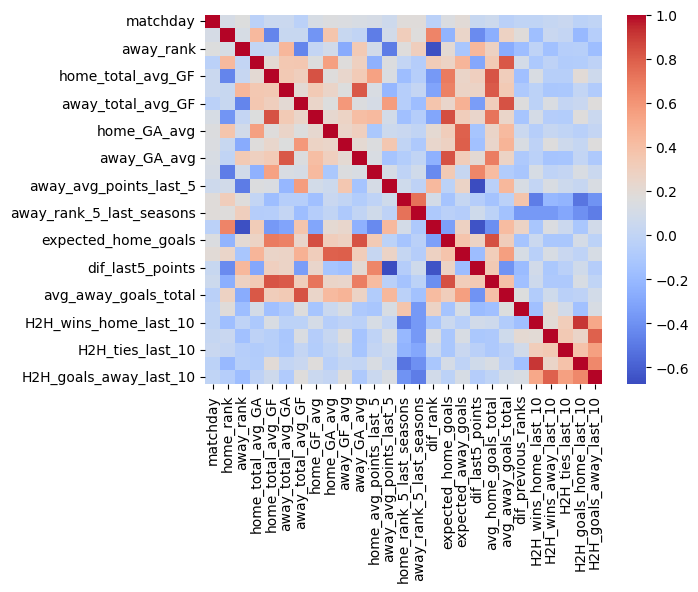

In [26]:
sns.heatmap(X.corr(),cmap='coolwarm')

In [27]:
feature_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_.sum()

print(f"Number of components selected: {pca.n_components_}")
print(f"Total variance explained: {explained_variance:.2f}")



Number of components selected: 10
Total variance explained: 0.87


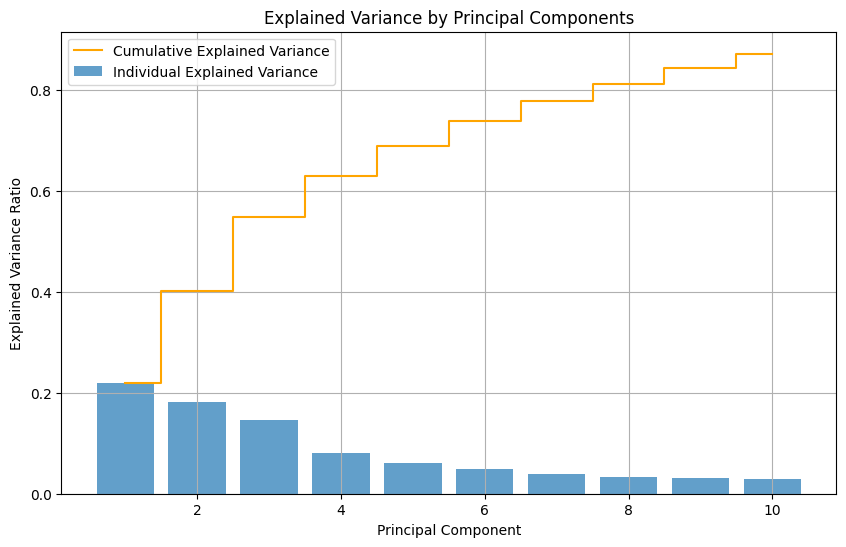

In [28]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot the variance explained by each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative Explained Variance', color='orange')

# Labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
components = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])

weighted_importance = components.abs().mul(explained_variance_ratio, axis=0)

total_weighted_importance = weighted_importance.sum(axis=0)

sorted_total_weighted_importance = total_weighted_importance.sort_values(ascending=False)

print("Sorted Total Feature Importance Across All Components (Weighted by Explained Variance):")
print(sorted_total_weighted_importance)

Sorted Total Feature Importance Across All Components (Weighted by Explained Variance):
home_GA_avg                 0.155698
expected_away_goals         0.153609
away_total_avg_GA           0.152895
home_total_avg_GA           0.151700
away_GF_avg                 0.148944
away_total_avg_GF           0.148633
home_avg_points_last_5      0.147450
avg_away_goals_total        0.145397
home_rank                   0.142571
away_rank_5_last_seasons    0.140240
home_total_avg_GF           0.137429
away_GA_avg                 0.136890
dif_last5_points            0.136663
away_rank                   0.136107
H2H_goals_away_last_10      0.133785
H2H_wins_away_last_10       0.132761
home_rank_5_last_seasons    0.131966
home_GF_avg                 0.131147
H2H_goals_home_last_10      0.125944
away_avg_points_last_5      0.125074
H2H_wins_home_last_10       0.124249
avg_home_goals_total        0.121521
expected_home_goals         0.120374
dif_previous_ranks          0.116840
dif_rank                

# Model training

We first defined a `performance` function to compute, for each ML algorithm, the performance metrics, and then created an empty data frame to store them.

In [30]:
# Empty df to store the performance of the different models
models_performance = pd.DataFrame(columns=['model', 'cv_avg_accuracy', 'weighted_f1', 'best_parameters'])

In [33]:
def performance(model, y_test, y_pred, plot=True):
    # Classificatin Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = class_report['accuracy']
    weighted_avg_f1 = class_report['weighted avg']['f1-score']

    if (plot):
        print(classification_report(y_test, y_pred))
        # Plot Confusion Matrix
        labels = ["Home Win", "Away Win", "Tie"]
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, weighted_avg_f1

We also define a `cross-validation` function:

In [34]:
def cross_val(model, X, y, param_grid, k=5, plot=True):

    grid_search = GridSearchCV(model, param_grid, cv=k, scoring='accuracy', n_jobs=-1)
    
    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_estimators = grid_search.best_params_

    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    
    fold_accuracies = []
    fold_f1 = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        accuracy, weighted_avg_f1 = performance(model, y_test, y_pred, plot)
        fold_accuracies.append(accuracy)
        fold_f1.append(weighted_avg_f1)

    # Calculate and print average accuracy
    cv_avg_accuracy = np.mean(fold_accuracies)
    cv_avg_weighted_f1 = np.mean(fold_f1)
    print(best_estimators)
    print(f"Average Accuracy over {k} folds: {cv_avg_accuracy:.4f}")
    print(f"Average Weighted F1 over {k} folds: {cv_avg_weighted_f1:.4f}")

    
    return best_estimators, cv_avg_accuracy, cv_avg_weighted_f1

In [ ]:
def cross_val(model, X, y, param_grid, k=5, plot=True, use_smote=False):
    
    
    grid_search = GridSearchCV(model, param_grid, cv=k, scoring='accuracy', n_jobs=-1)    
    
    if use_smote:
        smote = SMOTE(random_state=1)
        X_smote, y_smote = smote.fit_resample(X, y)
        grid_search.fit(X_smote, y_smote)

    else:
        grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_estimators = grid_search.best_params_

    # Step 2: K-Fold Cross Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    fold_accuracies = []
    fold_f1 = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if use_smote:
            smote = SMOTE(random_state=1)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        accuracy, weighted_avg_f1 = performance(model, y_test, y_pred, plot)
        fold_accuracies.append(accuracy)
        fold_f1.append(weighted_avg_f1)

    # Calculate and print average accuracy and weighted F1 score
    cv_avg_accuracy = np.mean(fold_accuracies)
    cv_avg_weighted_f1 = np.mean(fold_f1)
    print(best_estimators)
    print(f"Average Accuracy over {k} folds: {cv_avg_accuracy:.4f}")
    print(f"Average Weighted F1 over {k} folds: {cv_avg_weighted_f1:.4f}")

    return best_estimators, cv_avg_accuracy, cv_avg_weighted_f1

Example of not addressing the class imbalance problem, it basically predicts that the home team wins

              precision    recall  f1-score   support

           1       0.55      0.97      0.70      5058
           2       0.49      0.12      0.20      2070
           X       0.33      0.02      0.03      2469

    accuracy                           0.54      9597
   macro avg       0.45      0.37      0.31      9597
weighted avg       0.48      0.54      0.42      9597



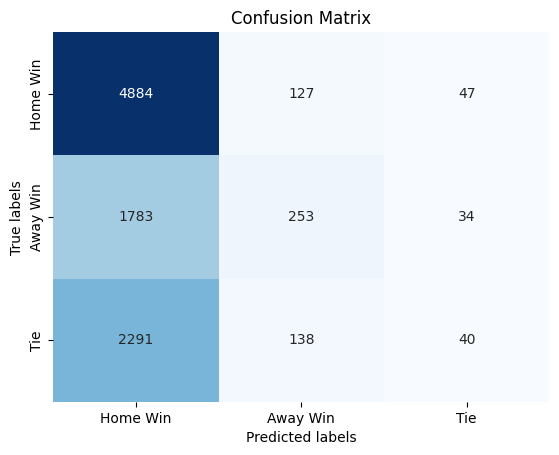

              precision    recall  f1-score   support

           1       0.55      0.95      0.70      5105
           2       0.41      0.13      0.20      2069
           X       0.27      0.01      0.03      2423

    accuracy                           0.54      9597
   macro avg       0.41      0.37      0.31      9597
weighted avg       0.45      0.54      0.42      9597



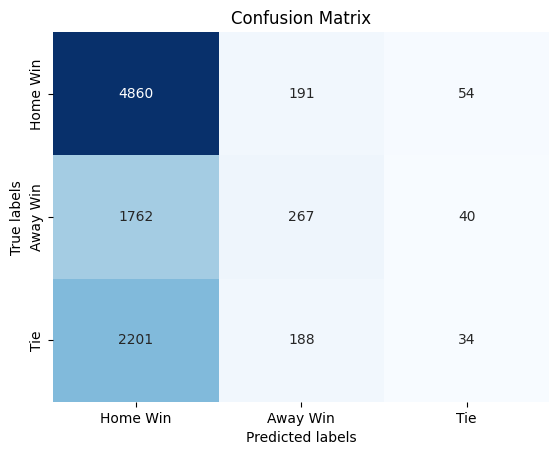

              precision    recall  f1-score   support

           1       0.54      0.95      0.69      5009
           2       0.46      0.14      0.21      2094
           X       0.31      0.02      0.04      2494

    accuracy                           0.53      9597
   macro avg       0.44      0.37      0.31      9597
weighted avg       0.46      0.53      0.42      9597



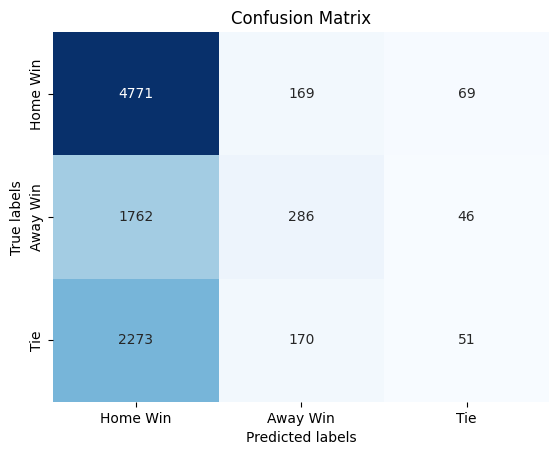

              precision    recall  f1-score   support

           1       0.55      0.95      0.69      5060
           2       0.39      0.12      0.18      2074
           X       0.30      0.02      0.03      2463

    accuracy                           0.53      9597
   macro avg       0.41      0.36      0.30      9597
weighted avg       0.45      0.53      0.41      9597



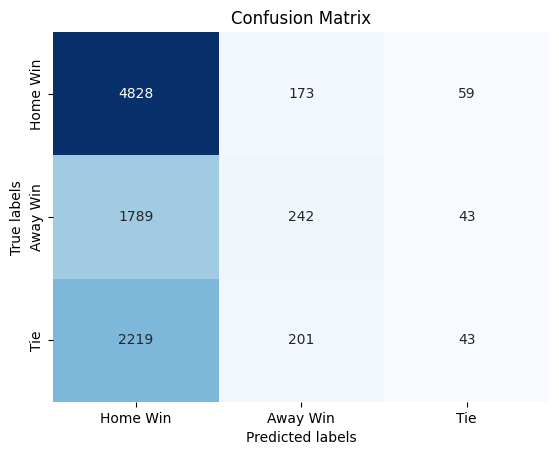

              precision    recall  f1-score   support

           1       0.55      0.95      0.69      5080
           2       0.39      0.13      0.19      2088
           X       0.24      0.01      0.03      2428

    accuracy                           0.53      9596
   macro avg       0.39      0.36      0.30      9596
weighted avg       0.44      0.53      0.42      9596



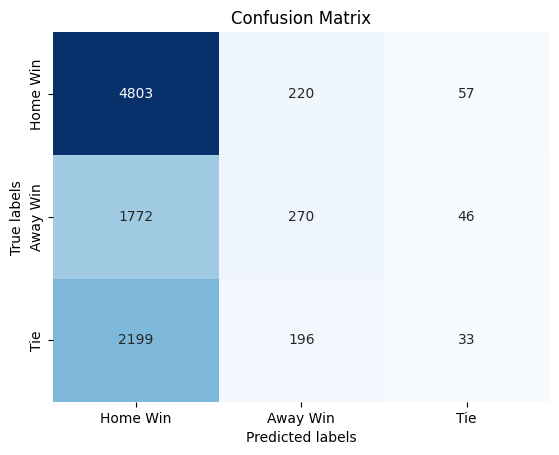

{'learning_rate': 0.1}
Average Accuracy over 5 folds: 0.5349
Average Weighted F1 over 5 folds: 0.4168


In [41]:
param_grid = {
    'learning_rate': [0.1]

}

hgb_model = HistGradientBoostingClassifier()
hgb_param, hgb_accuracy, hgb_f1_score = cross_val(hgb_model, X_pca, y, param_grid, plot=True, use_smote=False)
models_performance.loc[len(models_performance)] = [type(hgb_model).__name__, hgb_accuracy, 
                                                   hgb_f1_score, hgb_param]

## Histogram Gradient Boosting

              precision    recall  f1-score   support

           1       0.62      0.48      0.54      5058
           2       0.30      0.40      0.34      2070
           X       0.28      0.33      0.30      2469

    accuracy                           0.43      9597
   macro avg       0.40      0.40      0.40      9597
weighted avg       0.47      0.43      0.44      9597



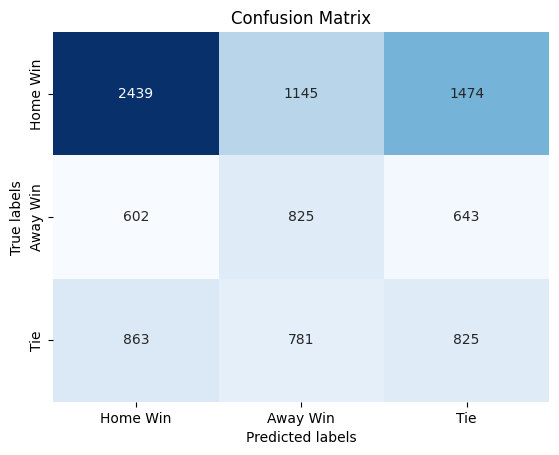

              precision    recall  f1-score   support

           1       0.63      0.48      0.55      5105
           2       0.28      0.39      0.32      2069
           X       0.29      0.34      0.31      2423

    accuracy                           0.43      9597
   macro avg       0.40      0.40      0.39      9597
weighted avg       0.47      0.43      0.44      9597



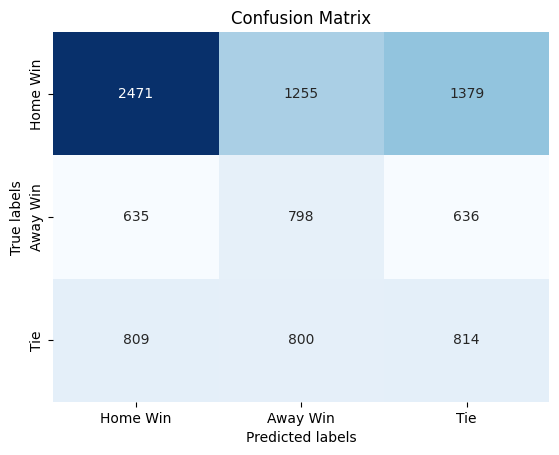

              precision    recall  f1-score   support

           1       0.61      0.48      0.54      5009
           2       0.30      0.40      0.34      2094
           X       0.29      0.34      0.31      2494

    accuracy                           0.43      9597
   macro avg       0.40      0.41      0.40      9597
weighted avg       0.46      0.43      0.44      9597



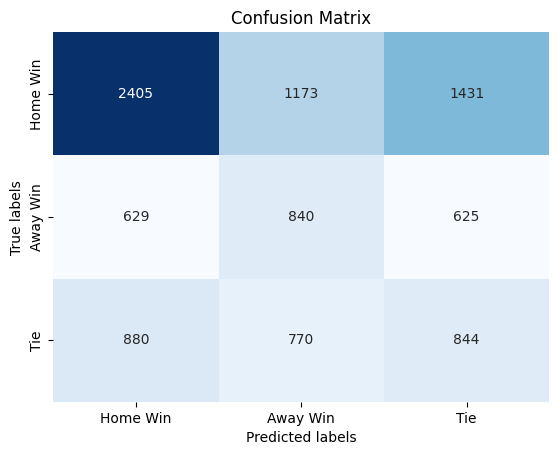

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      5060
           2       0.29      0.38      0.33      2074
           X       0.28      0.33      0.31      2463

    accuracy                           0.43      9597
   macro avg       0.40      0.40      0.40      9597
weighted avg       0.47      0.43      0.44      9597



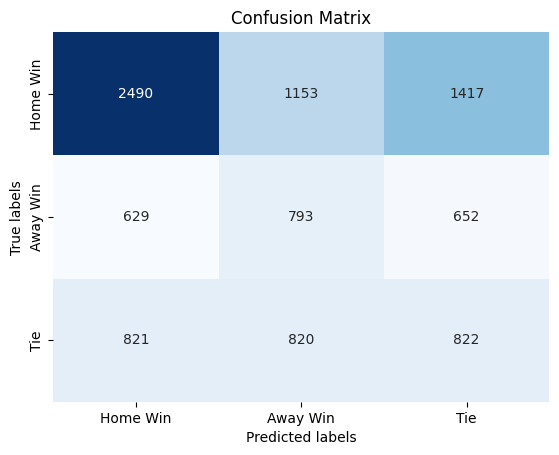

              precision    recall  f1-score   support

           1       0.62      0.49      0.55      5080
           2       0.29      0.37      0.32      2088
           X       0.27      0.32      0.29      2428

    accuracy                           0.42      9596
   macro avg       0.39      0.40      0.39      9596
weighted avg       0.46      0.42      0.44      9596



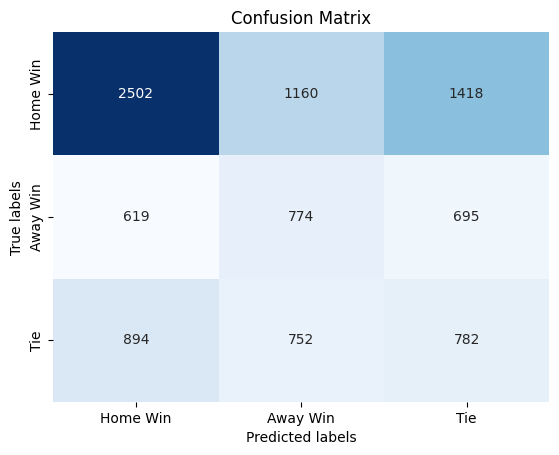

{'l2_regularization': 0, 'learning_rate': 0.2, 'max_depth': None}
Average Accuracy over 5 folds: 0.4256
Average Weighted F1 over 5 folds: 0.4388


In [42]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20],
    'l2_regularization': [0, 0.1, 0.5]
}
hgb_model = HistGradientBoostingClassifier()
hgb_param, hgb_accuracy, hgb_f1_score = cross_val(hgb_model, X_pca, y, param_grid, plot=True, use_smote=True)
models_performance.loc[len(models_performance)] = [type(hgb_model).__name__, hgb_accuracy, 
                                                   hgb_f1_score, hgb_param]

## Gradient Boosting

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}
gb_model = GradientBoostingClassifier()
gb_param, gb_accuracy, gb_f1_score = cross_val(gb_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(gb_model).__name__, gb_accuracy, 
                                                   gb_f1_score, gb_param]

{'learning_rate': 0.1, 'n_estimators': 50}
Average Accuracy over 5 folds: 0.5361
Average Weighted F1 over 5 folds: 0.4077


## Logistic Regression

In [50]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}
LR_model = LogisticRegression()
LR_param, LR_accuracy, LR_f1_score = cross_val(LR_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(LR_model).__name__, LR_accuracy, 
                                                   LR_f1_score, LR_param]

/home/manu/RI/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/manu/RI/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/manu/RI/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/manu/RI/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/manu/RI/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/manu/RI/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:34

{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Average Accuracy over 5 folds: 0.4480
Average Weighted F1 over 5 folds: 0.4587


## Naive Bayes

In [51]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}
NB_model = GaussianNB()
NB_param, NB_accuracy, NB_f1_score = cross_val(NB_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(NB_model).__name__, NB_accuracy, 
                                                   NB_f1_score, NB_param]

{'var_smoothing': 1e-09}
Average Accuracy over 5 folds: 0.4204
Average Weighted F1 over 5 folds: 0.4341


## kNN

              precision    recall  f1-score   support

           1       0.58      0.42      0.49      5058
           2       0.24      0.33      0.28      2070
           X       0.27      0.33      0.29      2469

    accuracy                           0.38      9597
   macro avg       0.36      0.36      0.35      9597
weighted avg       0.43      0.38      0.39      9597



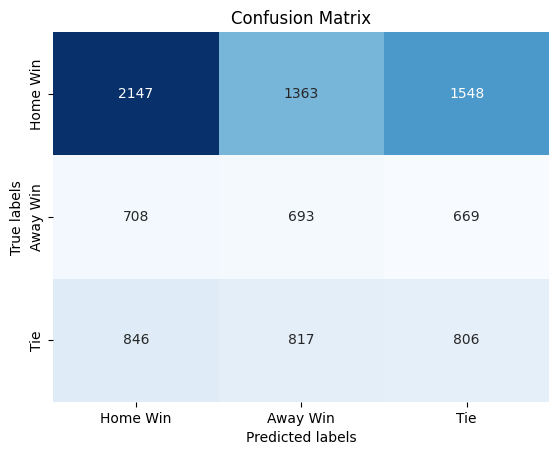

              precision    recall  f1-score   support

           1       0.59      0.42      0.49      5105
           2       0.25      0.35      0.29      2069
           X       0.26      0.34      0.30      2423

    accuracy                           0.39      9597
   macro avg       0.37      0.37      0.36      9597
weighted avg       0.43      0.39      0.40      9597



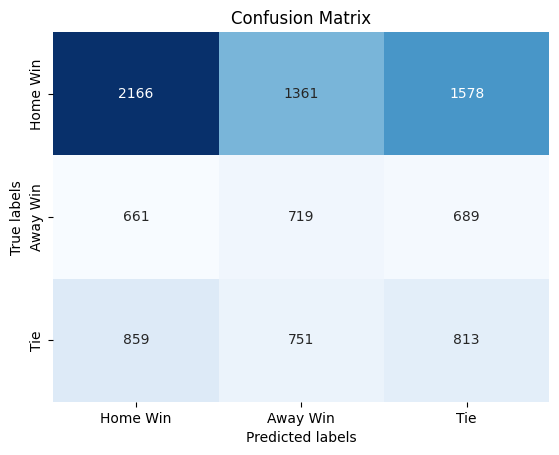

              precision    recall  f1-score   support

           1       0.57      0.43      0.49      5009
           2       0.26      0.34      0.29      2094
           X       0.27      0.35      0.31      2494

    accuracy                           0.39      9597
   macro avg       0.37      0.37      0.36      9597
weighted avg       0.43      0.39      0.40      9597



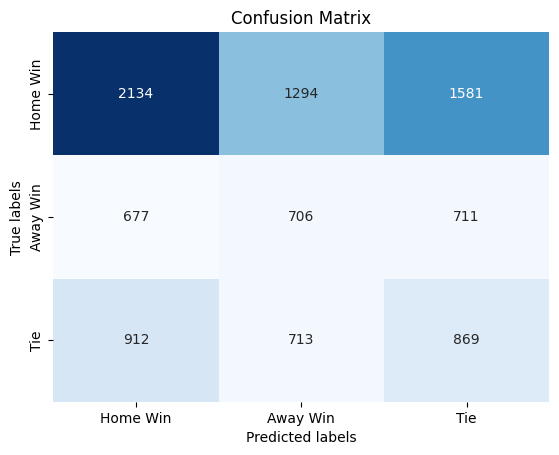

              precision    recall  f1-score   support

           1       0.59      0.43      0.49      5060
           2       0.26      0.35      0.30      2074
           X       0.27      0.33      0.29      2463

    accuracy                           0.39      9597
   macro avg       0.37      0.37      0.36      9597
weighted avg       0.43      0.39      0.40      9597



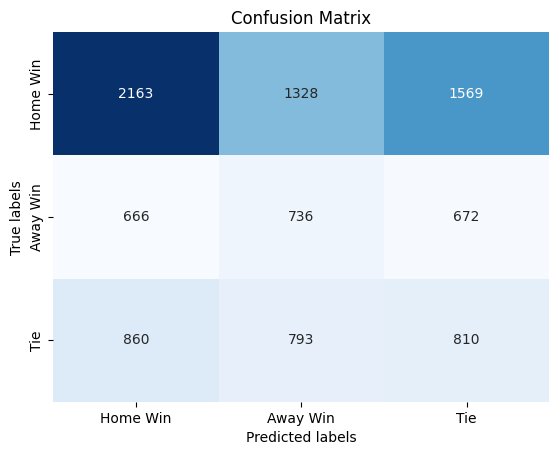

              precision    recall  f1-score   support

           1       0.57      0.42      0.49      5080
           2       0.26      0.34      0.29      2088
           X       0.25      0.33      0.29      2428

    accuracy                           0.38      9596
   macro avg       0.36      0.36      0.36      9596
weighted avg       0.42      0.38      0.39      9596



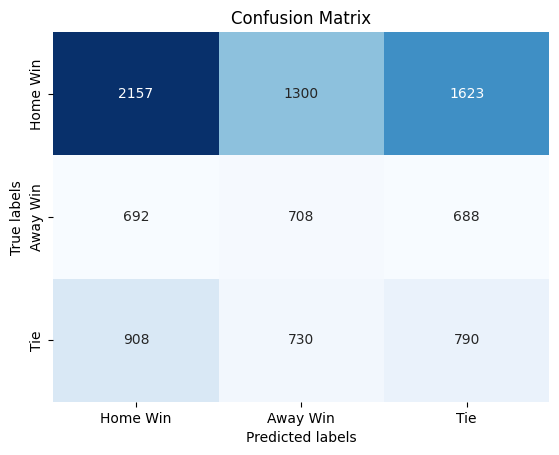

{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Average Accuracy over 5 folds: 0.3838
Average Weighted F1 over 5 folds: 0.3977


In [53]:
param_grid = {
    'n_neighbors': [3, 5, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean']
}
kNN_model = KNeighborsClassifier(n_jobs=-1)
kNN_param, kNN_accuracy, kNN_f1_score = cross_val(kNN_model, X_pca, y, param_grid, plot = True,use_smote=True)
models_performance.loc[len(models_performance)] = [type(kNN_model).__name__, kNN_accuracy, 
                                                   kNN_f1_score, kNN_param]

## Decision Tree

In [54]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5]

}
tree_model = DecisionTreeClassifier()
tree_param, tree_accuracy, tree_f1_score = cross_val(tree_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(tree_model).__name__, tree_accuracy, 
                                                   tree_f1_score, tree_param]

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Average Accuracy over 5 folds: 0.3810
Average Weighted F1 over 5 folds: 0.3960


## Random Forest

              precision    recall  f1-score   support

           1       0.65      0.48      0.55      5058
           2       0.32      0.40      0.36      2070
           X       0.29      0.39      0.34      2469

    accuracy                           0.44      9597
   macro avg       0.42      0.42      0.41      9597
weighted avg       0.49      0.44      0.45      9597



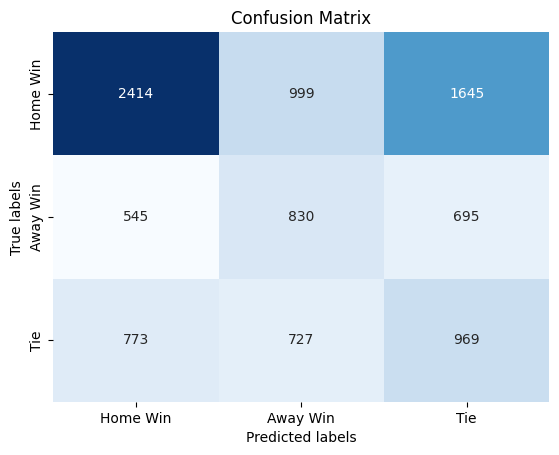

              precision    recall  f1-score   support

           1       0.64      0.48      0.55      5105
           2       0.31      0.44      0.37      2069
           X       0.29      0.35      0.32      2423

    accuracy                           0.44      9597
   macro avg       0.42      0.42      0.41      9597
weighted avg       0.48      0.44      0.45      9597



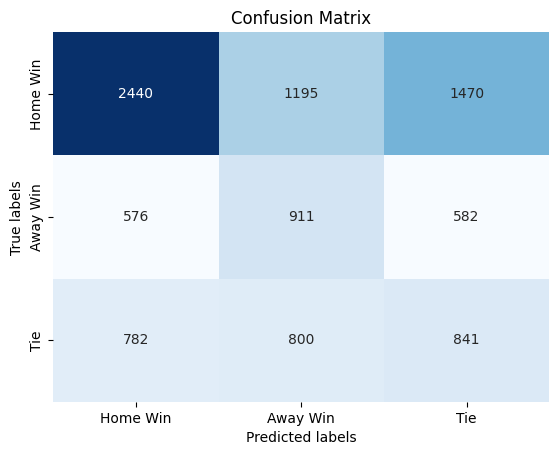

              precision    recall  f1-score   support

           1       0.64      0.49      0.55      5009
           2       0.32      0.42      0.36      2094
           X       0.30      0.38      0.34      2494

    accuracy                           0.44      9597
   macro avg       0.42      0.43      0.42      9597
weighted avg       0.48      0.44      0.46      9597



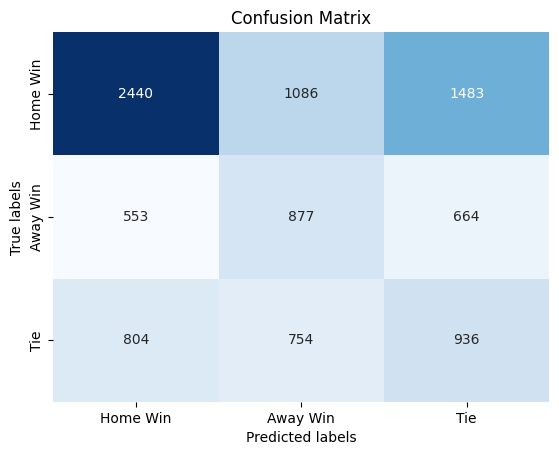

              precision    recall  f1-score   support

           1       0.66      0.50      0.57      5060
           2       0.31      0.39      0.35      2074
           X       0.30      0.40      0.34      2463

    accuracy                           0.45      9597
   macro avg       0.43      0.43      0.42      9597
weighted avg       0.49      0.45      0.46      9597



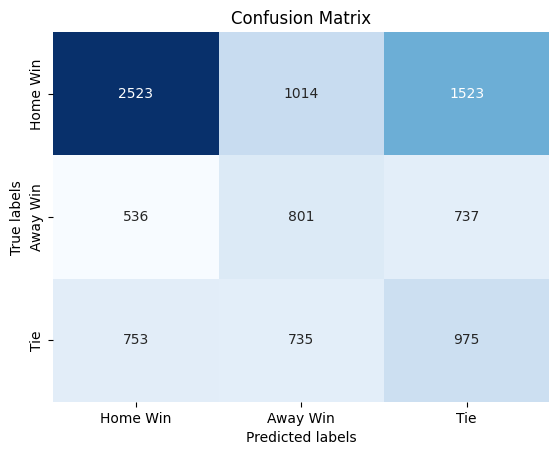

              precision    recall  f1-score   support

           1       0.65      0.50      0.56      5080
           2       0.32      0.40      0.35      2088
           X       0.28      0.36      0.32      2428

    accuracy                           0.44      9596
   macro avg       0.42      0.42      0.41      9596
weighted avg       0.48      0.44      0.46      9596



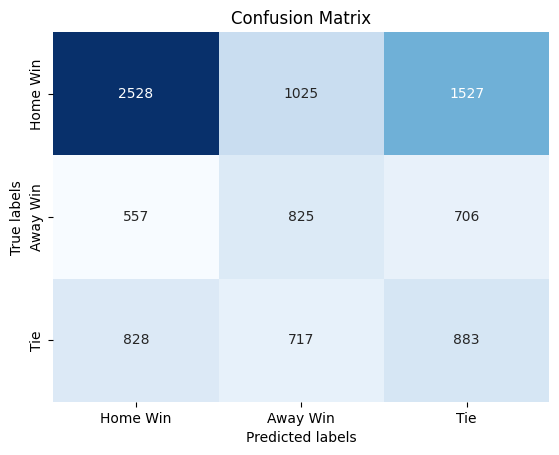

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Average Accuracy over 5 folds: 0.4417
Average Weighted F1 over 5 folds: 0.4555


In [55]:
param_grid = {
    'n_estimators': [50, 300],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 5]
}
RF_model = RandomForestClassifier()
RF_param, RF_accuracy, RF_f1_score = cross_val(RF_model, X_pca, y, param_grid, plot = True,use_smote=True)
models_performance.loc[len(models_performance)] = [type(RF_model).__name__, RF_accuracy, 
                                                   RF_f1_score, RF_param]

## Best model?

In [75]:
models_performance = models_performance.sort_values(['cv_avg_accuracy'], ascending=False)
models_performance

,model,cv_avg_accuracy,weighted_f1,best_parameters
4,GradientBoostingClassifier,0.536116,0.407742,"{'learning_rate': 0.1, 'n_estimators': 50}"
5,LogisticRegression,0.535428,0.410743,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}"
2,HistGradientBoostingClassifier,0.534866,0.416760,{'learning_rate': 0.1}
8,DecisionTreeClassifier,0.533386,0.393133,"{'criterion': 'gini', 'max_depth': 3, 'min_sam..."
6,GaussianNB,0.533365,0.421108,{'var_smoothing': 1e-09}
7,KNeighborsClassifier,0.511629,0.443737,"{'metric': 'manhattan', 'n_neighbors': 15, 'we..."
9,LogisticRegression,0.448003,0.458666,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}"
13,RandomForestClassifier,0.441668,0.455506,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
0,HistGradientBoostingClassifier,0.436812,0.451377,"{'l2_regularization': 0, 'learning_rate': 0.01..."
1,HistGradientBoostingClassifier,0.428247,0.441496,"{'l2_regularization': 0.1, 'learning_rate': 0...."


### ROC-AUC Curve of the best model

Micro-averaged One-vs-Rest ROC AUC score:
0.70
Macro-averaged One-vs-Rest ROC AUC score:
0.62


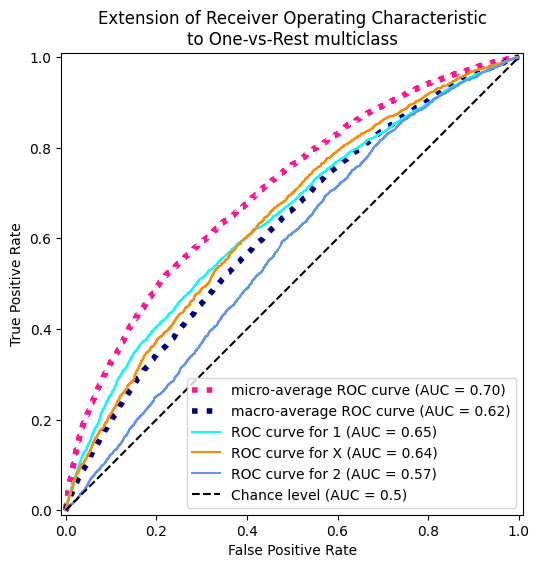

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

clf = LogisticRegression(C=0.01,penalty='l1',solver='saga')  # Set max_iter higher if convergence issues occur
y_score  = clf.fit(X_train, y_train).predict_proba(X_test)


label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, roc_auc = dict(), dict(), dict()

fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(3):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 3

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

fig, ax = plt.subplots(figsize=(6, 6))
target_names = ['1','X','2']
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)